In [13]:
PROJECT_NAME = 'resnet152.a3_in1k'

# Import

In [14]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


In [15]:
import timm

In [16]:
try:
    import wandb
except:
    !pip install wandb
    import wandb

wandb.login()
# wandb.login(secret_value_0)

wandb: Currently logged in as: demonkane007 (oral_dai). Use `wandb login --relogin` to force relogin


True

In [17]:
import pandas as pd
import os
from pathlib import Path


import torch

from torch.utils.data import DataLoader

"""
Contains functions for training and testing a PyTorch model.
"""

from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [18]:
from dataset_helper import ImageFolderCustom
from model_engine import Engine
from helper_plot import plot_torch_hist

# Directory

In [19]:
data_path = Path('/kaggle/input/oc-dataset-1/patches')

In [20]:
image_dir = data_path / 'images'
train_df = pd.read_csv(data_path/'sabpatch_parsed_folders.csv')
train_ds = train_df[['path','lesion']]
test_df = pd.read_csv(data_path/'sabpatch_parsed_test.csv')
test_ds = test_df[['path','lesion']]

# Global Parameters

In [21]:
ALPHA = 0.0001 ## Learning Rate
EPOCH = 50  ## Epochs
BATCH_SIZE = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DROPOUT = 0.5
PATIENCE = 10

# MEAN = [0.485, 0.456, 0.406]
# STD = [0.229, 0.224, 0.225]

In [22]:
model = timm.create_model(
    'resnet152.a3_in1k',
    pretrained=True,
    num_classes=3,  # remove classifier nn.Linear
    drop_rate = DROPOUT
)

data_config = timm.data.resolve_model_data_config(model)
train_transforms = timm.data.create_transform(**data_config, 
                                        is_training=True,
                                                                
)
test_transforms = timm.data.create_transform(**data_config, 
                                             is_training=False)

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [23]:
# import torchvision

In [24]:
# model = torchvision.models.mobilenetv3(pretrained=True)
# model

In [25]:
# feats_list = list(model.features)
# new_feats_list = []
# for feat in feats_list:
#     new_feats_list.append(feat)
#     if isinstance(feat, nn.Conv2d):
#         new_feats_list.append(nn.Dropout(p=0.5, inplace=True))

# # modify convolution layers
# model.features = nn.Sequential(*new_feats_list)


In [26]:
# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), 
#                                       ratio=(0.75, 1.3333), interpolation=transforms.InterpolationMode.BICUBIC),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.ColorJitter(brightness=(0.6, 1.4), 
#                 contrast=(0.6, 1.4), 
#                 saturation=(0.6, 1.4), hue=0),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), 
#               std=([0.2290, 0.2240, 0.2250])),
# ])

# test_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), 
#               std=([0.2290, 0.2240, 0.2250])),
# ])

In [27]:
train_transforms

Compose(
    RandomResizedCropAndInterpolation(size=(160, 160), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [28]:
# from torch.utils.data import default_collate
# from torchvision.transforms import v2

# def collate_fn(batch):
#     return cutmix_or_mixup(*default_collate(batch))

# cutmix = v2.CutMix(num_classes=3)
# mixup = v2.MixUp(num_classes=3)
# cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

In [29]:
    train_data = ImageFolderCustom(targ_dir = image_dir,
                                          path_df = train_ds,
                                          transform= train_transforms)

    test_data = ImageFolderCustom(targ_dir = image_dir,
                                          path_df = test_ds,
                                          transform= test_transforms)
    
    classes, class_to_idx = train_data.find_classes()

/kaggle/usr/lib/dataset-helper/dataset_helper.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.img_df['path'] = self.check_path(targ_dir)


In [30]:
train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                        batch_size=BATCH_SIZE, # how many samples per batch?
                                        num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                        shuffle=True, # shuffle the data?
                                        )

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                        batch_size=BATCH_SIZE,
                                        num_workers=0,
                                        shuffle=False) # don't usually need to shuffle testing data


In [31]:
    wandb.init(
    project=PROJECT_NAME,
    config={
            "epochs": EPOCH,
            "batch_size": BATCH_SIZE,
            "lr": ALPHA,
            "architecture": "CNN",
            "dropout": DROPOUT,
            "patience":PATIENCE,
            "model":'DenseNet201',
            })


In [32]:
loss_fn = nn.CrossEntropyLoss(reduction='sum') # computes the cross entropy loss between input logits and target.

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
Engine = Engine(model=model, loss_fn=loss_fn, optimizer=optimizer, device=device, early_stopping=True , config = wandb.config, dirpath = '/kaggle/working/model_weights')
result = Engine.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader, epochs=EPOCH, verbose=True, patience=PATIENCE)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Epoch 1/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 1/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 1 | train_loss: 32.6376 | train_acc: 0.4965 | test_loss: 30.3459 | test_acc: 0.5167


Epoch 2/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 2/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 2 | train_loss: 30.0130 | train_acc: 0.5577 | test_loss: 27.4304 | test_acc: 0.6124


Epoch 3/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 3/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 3 | train_loss: 27.8210 | train_acc: 0.6014 | test_loss: 24.5360 | test_acc: 0.6411


Epoch 4/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 4/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 4 | train_loss: 25.4352 | train_acc: 0.6301 | test_loss: 22.0966 | test_acc: 0.6906


Epoch 5/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 5/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 5 | train_loss: 23.9933 | train_acc: 0.6515 | test_loss: 20.7140 | test_acc: 0.7177


Epoch 6/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 6/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 6 | train_loss: 22.9137 | train_acc: 0.6763 | test_loss: 19.3426 | test_acc: 0.7177


Epoch 7/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 7/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 7 | train_loss: 21.9524 | train_acc: 0.6802 | test_loss: 18.2222 | test_acc: 0.7544


Epoch 8/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 8/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 8 | train_loss: 21.6417 | train_acc: 0.6939 | test_loss: 17.6438 | test_acc: 0.7384


Epoch 9/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 9/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 9 | train_loss: 21.3047 | train_acc: 0.6942 | test_loss: 16.7264 | test_acc: 0.7751


Epoch 10/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 10/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 10 | train_loss: 20.6710 | train_acc: 0.7095 | test_loss: 16.4917 | test_acc: 0.7656


Epoch 11/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 11/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 11 | train_loss: 20.1730 | train_acc: 0.7207 | test_loss: 15.6478 | test_acc: 0.7895


Epoch 12/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 12/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 12 | train_loss: 20.2371 | train_acc: 0.7105 | test_loss: 15.3129 | test_acc: 0.8006


Epoch 13/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 13/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 13 | train_loss: 19.0089 | train_acc: 0.7286 | test_loss: 15.0278 | test_acc: 0.7847


Epoch 14/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 14/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 14 | train_loss: 18.3772 | train_acc: 0.7404 | test_loss: 14.4028 | test_acc: 0.7974


Epoch 15/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 15/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 15 | train_loss: 18.0370 | train_acc: 0.7557 | test_loss: 14.2396 | test_acc: 0.7879


Epoch 16/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 16/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 16 | train_loss: 18.2454 | train_acc: 0.7500 | test_loss: 13.7800 | test_acc: 0.8054


Epoch 17/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 17/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 17 | train_loss: 17.5696 | train_acc: 0.7538 | test_loss: 13.2501 | test_acc: 0.7990


Epoch 18/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 18/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 18 | train_loss: 17.1768 | train_acc: 0.7634 | test_loss: 12.7714 | test_acc: 0.8102


Epoch 19/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 19/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 19 | train_loss: 17.0972 | train_acc: 0.7672 | test_loss: 12.7872 | test_acc: 0.8182
Early stopping counter: 1 out of 10


Epoch 20/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 20/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 20 | train_loss: 16.6209 | train_acc: 0.7806 | test_loss: 12.1507 | test_acc: 0.8437


Epoch 21/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 21/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 21 | train_loss: 16.1118 | train_acc: 0.7768 | test_loss: 11.5224 | test_acc: 0.8405


Epoch 22/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 22/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 22 | train_loss: 15.9846 | train_acc: 0.7838 | test_loss: 11.6632 | test_acc: 0.8357
Early stopping counter: 1 out of 10


Epoch 23/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 23/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 23 | train_loss: 14.8738 | train_acc: 0.7975 | test_loss: 10.4848 | test_acc: 0.8565


Epoch 24/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 24/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 24 | train_loss: 15.0462 | train_acc: 0.7972 | test_loss: 11.3352 | test_acc: 0.8549
Early stopping counter: 1 out of 10


Epoch 25/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 25/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 25 | train_loss: 14.7233 | train_acc: 0.7972 | test_loss: 11.5599 | test_acc: 0.8485
Early stopping counter: 2 out of 10


Epoch 26/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 26/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 26 | train_loss: 15.3908 | train_acc: 0.8007 | test_loss: 10.4127 | test_acc: 0.8581


Epoch 27/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 27/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 27 | train_loss: 14.7347 | train_acc: 0.8026 | test_loss: 10.1192 | test_acc: 0.8612


Epoch 28/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 28/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 28 | train_loss: 14.2315 | train_acc: 0.8138 | test_loss: 9.9716 | test_acc: 0.8692


Epoch 29/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 29/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 29 | train_loss: 14.1450 | train_acc: 0.8131 | test_loss: 10.0376 | test_acc: 0.8644
Early stopping counter: 1 out of 10


Epoch 30/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 30/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 30 | train_loss: 13.7752 | train_acc: 0.8189 | test_loss: 10.5074 | test_acc: 0.8581
Early stopping counter: 2 out of 10


Epoch 31/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 31/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 31 | train_loss: 13.5763 | train_acc: 0.8237 | test_loss: 10.1943 | test_acc: 0.8644
Early stopping counter: 3 out of 10


Epoch 32/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 32/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 32 | train_loss: 13.2507 | train_acc: 0.8217 | test_loss: 9.6202 | test_acc: 0.8724


Epoch 33/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 33/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 33 | train_loss: 12.7014 | train_acc: 0.8329 | test_loss: 9.4412 | test_acc: 0.8868


Epoch 34/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 34/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 34 | train_loss: 12.9757 | train_acc: 0.8294 | test_loss: 10.3176 | test_acc: 0.8756
Early stopping counter: 1 out of 10


Epoch 35/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 35/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 35 | train_loss: 13.0252 | train_acc: 0.8291 | test_loss: 10.0109 | test_acc: 0.8692
Early stopping counter: 2 out of 10


Epoch 36/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 36/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 36 | train_loss: 12.9649 | train_acc: 0.8358 | test_loss: 9.2451 | test_acc: 0.8884


Epoch 37/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 37/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 37 | train_loss: 12.1410 | train_acc: 0.8402 | test_loss: 9.5527 | test_acc: 0.8884
Early stopping counter: 1 out of 10


Epoch 38/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 38/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 38 | train_loss: 12.6770 | train_acc: 0.8364 | test_loss: 9.3771 | test_acc: 0.8900
Early stopping counter: 2 out of 10


Epoch 39/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 39/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 39 | train_loss: 11.9975 | train_acc: 0.8489 | test_loss: 9.1467 | test_acc: 0.8979


Epoch 40/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 40/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 40 | train_loss: 11.6995 | train_acc: 0.8438 | test_loss: 9.5593 | test_acc: 0.8852
Early stopping counter: 1 out of 10


Epoch 41/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 41/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 41 | train_loss: 11.2038 | train_acc: 0.8603 | test_loss: 9.7085 | test_acc: 0.8995
Early stopping counter: 2 out of 10


Epoch 42/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 42/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 42 | train_loss: 10.9940 | train_acc: 0.8552 | test_loss: 9.8180 | test_acc: 0.8820
Early stopping counter: 3 out of 10


Epoch 43/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 43/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 43 | train_loss: 11.6069 | train_acc: 0.8540 | test_loss: 8.8537 | test_acc: 0.9011


Epoch 44/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 44/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 44 | train_loss: 10.9809 | train_acc: 0.8597 | test_loss: 9.7378 | test_acc: 0.9059
Early stopping counter: 1 out of 10


Epoch 45/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 45/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 45 | train_loss: 10.7950 | train_acc: 0.8626 | test_loss: 8.5092 | test_acc: 0.9155


Epoch 46/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 46/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 46 | train_loss: 10.2423 | train_acc: 0.8734 | test_loss: 8.8261 | test_acc: 0.8979
Early stopping counter: 1 out of 10


Epoch 47/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 47/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 47 | train_loss: 9.5413 | train_acc: 0.8814 | test_loss: 9.0079 | test_acc: 0.9123
Early stopping counter: 2 out of 10


Epoch 48/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 48/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 48 | train_loss: 10.7498 | train_acc: 0.8670 | test_loss: 8.8729 | test_acc: 0.9107
Early stopping counter: 3 out of 10


Epoch 49/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 49/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 49 | train_loss: 10.4824 | train_acc: 0.8645 | test_loss: 8.9306 | test_acc: 0.8947
Early stopping counter: 4 out of 10


Epoch 50/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 50/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 50 | train_loss: 9.2704 | train_acc: 0.8862 | test_loss: 8.7863 | test_acc: 0.8931
Early stopping counter: 5 out of 10


test/test_acc,▁▃▃▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█████▇██████
test/test_loss,█▇▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/train_acc,▁▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█████
train/train_loss,█▇▇▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
test/test_acc,0.89314
test/test_loss,8.78627
train/epoch,73.5
train/train_acc,0.88616
train/train_loss,9.27045


[INFO] Total training time: 3884.181 seconds


In [33]:
result_df = pd.DataFrame(result)
# result_df.head()

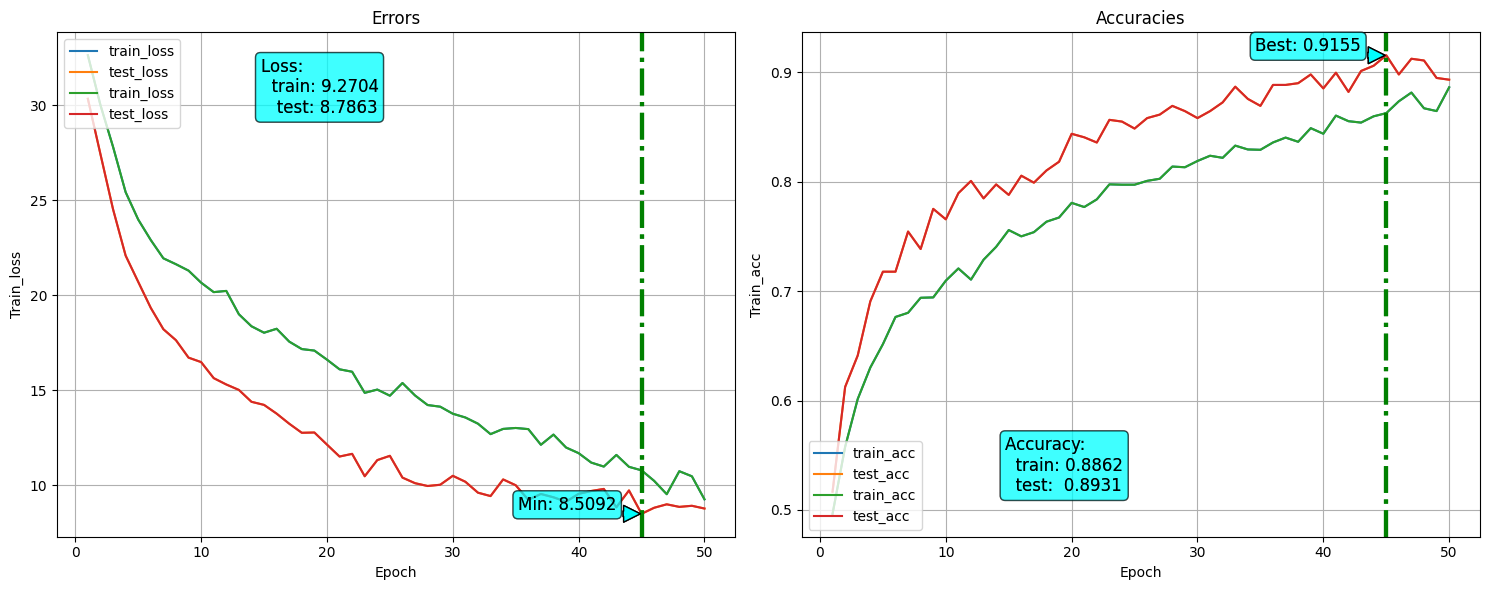

In [34]:
plot_torch_hist(result_df)

In [35]:
# train_transforms

In [36]:
!pip install torchview
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(32,3,224,224), expand_nested=True)
model_arc = model_graph.visual_graph